# SK Part 2: Feature Selection and Ranking

### Table of Contents
- Data Preparation
- Performance with Full Set of Features
- Feature Selection Using F-Score
- Feature Selection Using Mutual Information
- Feature Selection Using Random Forest Importance
- Feature Selection Using spFSR
- Performance Comparison Using Paired T-Tests

## Data Prepration

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import io
import requests

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold    
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('C:/Users/piyus/OneDrive/Desktop/Brushing/Machine Learning/practice/data/breast_cancer_wisconsin.csv')

In [3]:
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


Let's do some pre-processing:

- Split the dataset columns into Data and target.
- Make target numeric by label-encoding.
- Normalize each descriptive feature in Data to be between 0 and 1.

In [4]:
Data = df.drop(columns='diagnosis')
target = df['diagnosis']
Data = preprocessing.MinMaxScaler().fit_transform(Data)
target = preprocessing.LabelEncoder().fit_transform(target)

## Performance with Full Set of Features

As wrapper, we use the decision tree classifier with default values.

In [5]:
clf = DecisionTreeClassifier(random_state=999)

First, we would like to assess performance using all the features in the dataset. For assessment, we shall use stratified 5-fold cross-validation with 3 repetitions. We set the random state to 999 so that our results can be replicated and verified later on exactly as they are.

In [6]:
cross_val_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,
                                           random_state=999)

For scoring, we use the accuracy score.

In [7]:
scoring_metric = 'accuracy'

Let's perform the cross-validation using the cross_val_score function.

In [8]:
cv_results_full = cross_val_score(estimator=clf,
                                 X=Data,
                                 y=target,
                                 cv=cross_val_method,
                                 scoring=scoring_metric)

The array `cv_results_full` contains 15 values corresponding to each one of the 3-repetition/ 5-fold combinations.

In [9]:
cv_results_full

array([0.92105263, 0.95614035, 0.9122807 , 0.92105263, 0.97345133,
       0.94736842, 0.92982456, 0.87719298, 0.92105263, 0.92920354,
       0.9122807 , 0.92982456, 0.92105263, 0.95614035, 0.9380531 ])

We compute the average cross-validation performance as the mean of the `cv_results_full` array.

In [10]:
cv_results_full.mean().round(3)

0.93

Let's now select the best 5 features in the dataset using different methods.

In [11]:
num_features = 5

## Feature Selection Using F-Score
The F-Score method is a filter feature selection method that looks at the relationship between each descriptive feature and the target feature using the F-distribution.

The code below returns the indices of the 5 features that have the highest F-Score value sorted from the highest to the lowest. Pay attention that the wrapper is not used in any way when selecting features using the F-Score method.

In some cases, the F-Score will be "NaN" for some features due to technical reasons (related to the nature of the F-distribution). For this reason, we will convert any "NaN" value to zero for a correct result via the `np.nan_to_num()` method.

In [12]:
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]
# in above line we are using argsort fro sorting the data to ascending order and for reversing the sort we are using [::-1]
fs_indices_fscore

array([27, 22,  7, 20,  2], dtype=int64)

Let's see what these 5 best features are.

In [13]:
best_features_fscore = df.columns[fs_indices_fscore].values
best_features_fscore

array(['worst_concave_points', 'worst_perimeter', 'mean_concave_points',
       'worst_radius', 'mean_perimeter'], dtype=object)

Based on the F-Scores, we observe that, out of the top 5 features, the most important feature is "worst_concave_points" and the least important feature is "mean_perimeter".

The F-Score importances of these features are given below.

In [14]:
feature_importance_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importance_fscore

array([964.38539345, 897.94421886, 861.67602001, 860.78170699,
       697.23527248])

We define a function for plotting so that we can plot other importance types as well corresponding to different feature selection methods.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

def plt_imp(best_features, scores, method_name, color):
    plt.barh(best_features, scores, color=color)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel("Features")
    plt.show()

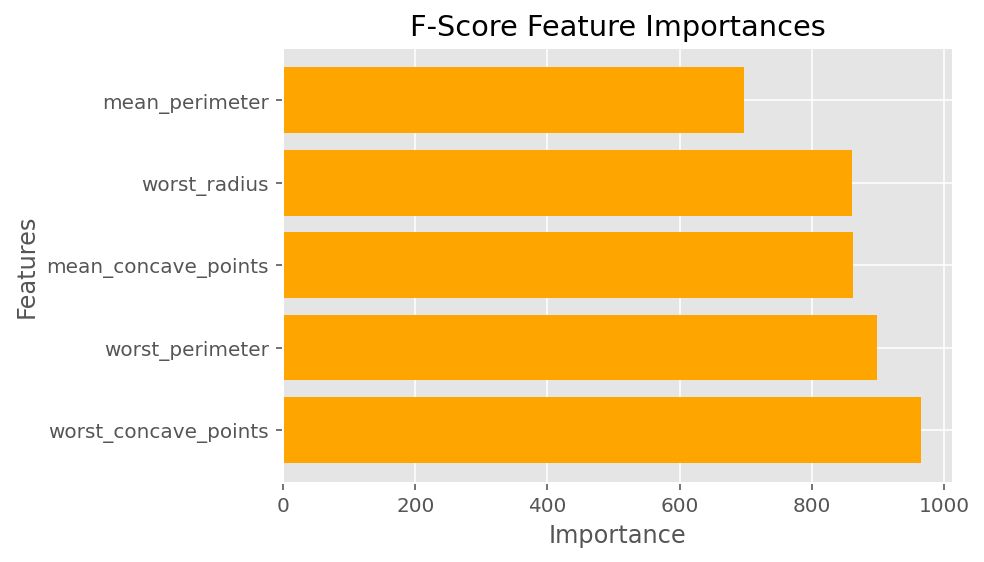

In [16]:
plt_imp(best_features_fscore, feature_importance_fscore, 'F-Score','orange')

We can select those features from the set of descriptive features Data using slicing as shown below.

In [17]:
Data[:, fs_indices_fscore].shape

(569, 5)

Let's now assess performance of this feature selection method using cross validation with the decision tree classifier.

In [18]:
cv_results_fscore = cross_val_score(estimator=clf,
                                   X=Data[:,fs_indices_fscore],
                                   y=target,
                                   cv=cross_val_method,
                                   scoring=scoring_metric)
cv_results_fscore.mean().round(3)

0.926

## Feature Selection Using Mutual Information
The mutual information method is a filter feature selection method that looks at the relationship between each descriptive feature and the target feature using the concept of entropy.

The code below returns the indices of the 5 features that have the highest mutual information value. As in the F-score method, the wrapper is not used in any way when selecting features using the mutual information method.

In [19]:
fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=num_features)
fs_fit_mutual_info.fit_transform(Data, target)
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]
best_features_mutual_info = df.columns[fs_indices_mutual_info].values
best_features_mutual_info

array(['worst_perimeter', 'worst_area', 'worst_radius',
       'mean_concave_points', 'worst_concave_points'], dtype=object)

In [20]:
feature_importance_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
feature_importance_mutual_info

array([0.4740346 , 0.46448559, 0.4532943 , 0.4393092 , 0.4388947 ])

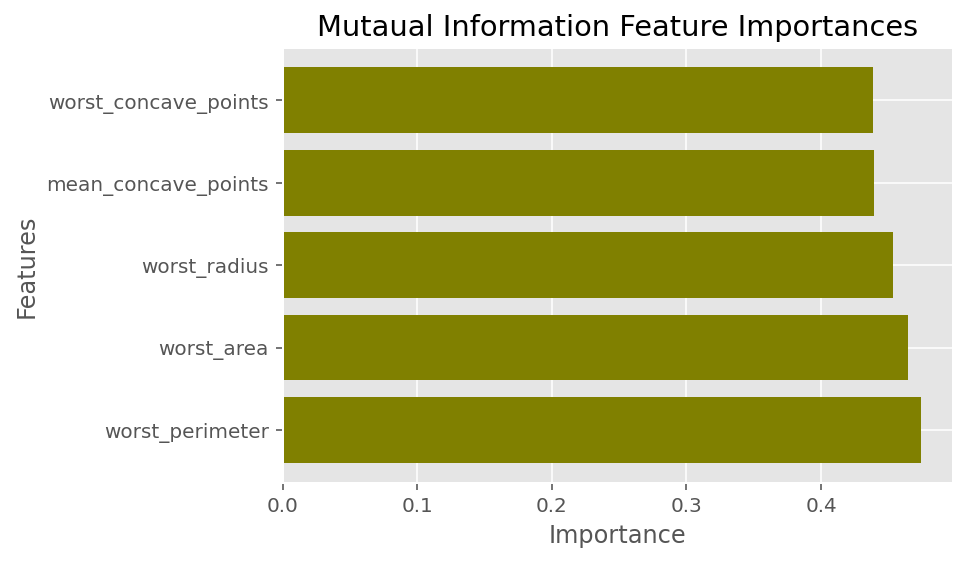

In [21]:
plt_imp(best_features_mutual_info,feature_importance_mutual_info,'Mutaual Information','olive')

Now, lets evaluate the perfomance of these feature

In [22]:
cv_results_mutual_info = cross_val_score(estimator=clf,
                                         X=Data[:,fs_indices_mutual_info],
                                         y=target,
                                         cv=cross_val_method,
                                         scoring=scoring_metric)
cv_results_mutual_info.mean().round(3)

0.919

## Feature Selection Using Random Forest Importance
The random forest importance (RFI) method is a filter feature selection method that uses the total decrease in node impurities from splitting on a particular feature as averaged over all decision trees in the ensemble. For classification, the node impurity is measured by the Gini index and for regression, it is measured by residual sum of squares.

Let's perform RFI feature selection using 100 trees.

In [23]:
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data,target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

Here are the best features selected by RFI

In [24]:
best_features_rfi = df.columns[fs_indices_rfi].values
best_features_rfi

array(['worst_radius', 'mean_concave_points', 'worst_perimeter',
       'worst_concave_points', 'worst_area'], dtype=object)

In [25]:
feature_importance_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importance_rfi

array([0.13445097, 0.12428932, 0.10059752, 0.09359598, 0.08867645])

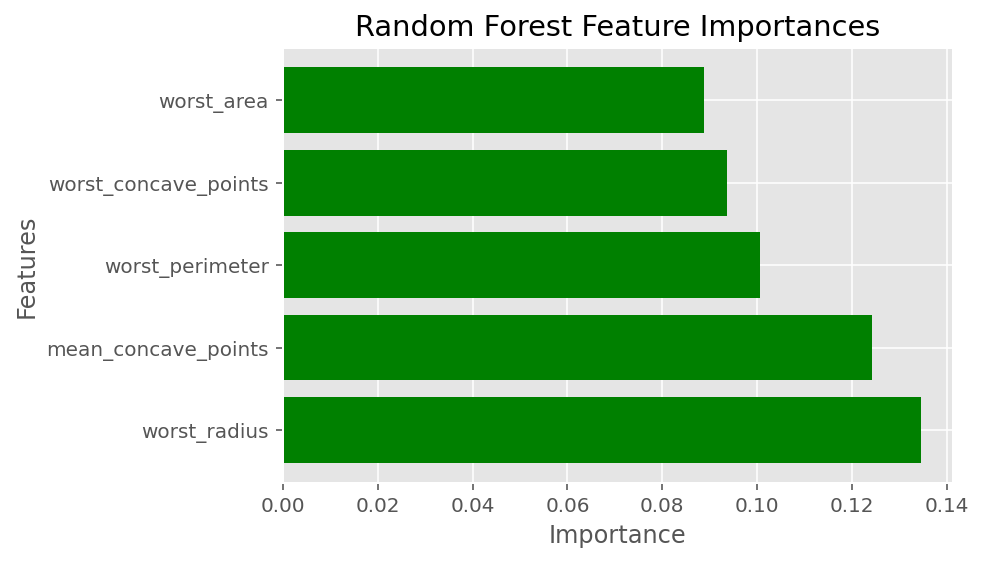

In [26]:
plt_imp(best_features_rfi, feature_importance_rfi,'Random Forest' ,'green')